In [ ]:
## this notebook will deteck anomalies from the pcap outputs.

import pandas as pd
import numpy as np

from torch import nn

import scipy
import matplotlib.pyplot as plt
import seaborn as sns


from data_extractors import advanced_process, basic_process

import os
import sys

##install pytorch

##install scikit-learn
from sklearn.preprocessing import  RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.feature_selection import SelectKBest, mutual_info_classif
## train test split import with cross fold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
##definition of the pytorch device since, it's a mac i will use mps for faster processing.
device = "mps"

In [84]:
current_wd = os.getcwd()

# advanced_csv = advanced_process(f"{current_wd}/pcap-files","adv.csv") ## this will likely cause errors now because the package is still getting collected in the background.

# basic_csv = basic_process(f"{current_wd}/pcap-files","basic.csv") 

#already processed the data so we can just load it in.

advanced_csv = f"{current_wd}/adv.csv"
basic_csv = f"{current_wd}/basic.csv"
adv_df = pd.read_csv(advanced_csv)
basic_df = pd.read_csv(basic_csv)

In [85]:
import pandas as pd
import scipy.stats

def get_stats(dataframe=pd.DataFrame()):
    """
    This function returns the statistics of the given dataframe.

    Parameters:
    dataframe: pd.DataFrame
        The dataframe to be analyzed.
    """
    try:
        display("--------------------")
        display("dataframe's shape is :")
        display(dataframe.shape)
        display("--------------------")
        display("dataframe's columns are :")
        display(dataframe.columns)
        display("--------------------")
        display("dataframe's info is :")
        display(dataframe.info())
        display("--------------------")
        display("dataframe's head is :")
        display(dataframe.head())
        display("--------------------")
        display("dataframe's tail is :")
        display(dataframe.tail())
        display("--------------------")
        display("dataframe's describe is :")
        display(dataframe.describe())
        display("--------------------")
        display("dataframe's null values are :")
        display(dataframe.isnull().sum())
        display("--------------------")
        display("dataframe's unique values are :")
        display(dataframe.nunique())
        display("--------------------")
        display("dataframe's data types are :")
        display(dataframe.dtypes)
        display("--------------------")
        display("dataframe's memory usage is :")
        display(dataframe.memory_usage())
        display("--------------------")

        ## SciPy stats of the dataframe
        display("dataframe's column stats are :")

        stats_list = []

        for col in adv_df.select_dtypes(include=['number']).columns:  

            baseline_values = adv_df[col][adv_df["is_baseline"] == True].dropna()
            non_baseline_values = adv_df[col][adv_df["is_baseline"] == False].dropna()
            
            #display(baseline_values)

            stats_list.append({
                "column name": col,
                "baseline_skewness": scipy.stats.skew(baseline_values),  
                "baseline_kurtosis": scipy.stats.kurtosis(baseline_values),  
                "anomaly_skewness": scipy.stats.skew(non_baseline_values),
                "anomaly_kurtosis": scipy.stats.kurtosis(non_baseline_values)
            })

        framey = pd.DataFrame(stats_list)
        display(framey)
        display("--------------------")


        ## Correlation of the columns
        display("dataframe's numerical correlation is :")
        ##display(dataframe.corr(numeric_only=True))
        sns.heatmap(dataframe.corr(numeric_only=True))
        plt.show()
        display("--------------------")

        ## Covariance of the columns
        display("dataframe's covariance is :")
        display(dataframe.cov(numeric_only=True))
        display("--------------------")


        ##plotitng every numerical variable's distribution.

        for col in dataframe.select_dtypes(include=["number"]).columns:
            sns.kdeplot(data=dataframe,x=col, hue="is_baseline",fill=True)
            plt.show()
        
        ## kdeplot only shows and looks upon the frenquencies. Try using other methods like using geometric mean for further graphical analysis
        display("dataframe's geometric mean is :")
        ##baseline geometric mean
        for col in dataframe[dataframe["is_baseline"] == True].select_dtypes(include=["number"]).columns:
            positive_values = dataframe[col][dataframe[col] > 0].dropna()
            if len(positive_values) != 0:
                display(f"Geometric mean of column {col} is {scipy.stats.gmean(positive_values)}")
            else: 
                display(f"function failed for column {col} due to no positive values")
         ## here is the non baseline geometric means for the data.       
        for col in dataframe[dataframe["is_baseline"] == False].select_dtypes(include=["number"]).columns:
            positive_values = dataframe[col][dataframe[col] > 0].dropna()
            if len(positive_values) != 0:
                display(f"Geometric mean of column {col} is {scipy.stats.gmean(positive_values)}")
            else: 
                display(f"function failed for column {col} due to no positive values") 

        ## comparison of the two set's geometric means and if they are statistically significant.
        for col in dataframe.select_dtypes(include=["number"]).columns:
            baseline_values = dataframe[col][dataframe["is_baseline"] == True].dropna()
            non_baseline_values = dataframe[col][dataframe["is_baseline"] == False].dropna()
            if len(baseline_values) != 0 and len(non_baseline_values) != 0:
                #display(f"Geometric mean of column {col} for baseline is {scipy.stats.gmean(baseline_values)}")
                #display(f"Geometric mean of column {col} for non-baseline is {scipy.stats.gmean(non_baseline_values)}")
                display(f"Statistical significance of the difference between the two sets is {scipy.stats.ttest_ind(baseline_values, non_baseline_values)}")
            else: 
                display(f"function failed for column {col} due to no positive values")      


    except Exception as e:
        print("An error occurred: ", e)
        return []


'--------------------'

"dataframe's shape is :"

(306, 37)

'--------------------'

"dataframe's columns are :"

Index(['window_id', 'window_start', 'packet_count', 'bytes_per_second',
       'avg_packet_size', 'packet_size_std', 'unique_protocols',
       'unique_src_ips', 'unique_dst_ips', 'unique_src_ports',
       'unique_dst_ports', 'unique_ip_pairs', 'unique_port_pairs',
       'unique_connections', 'dns_query_count', 'bytes_in', 'bytes_out',
       'packets_in', 'packets_out', 'io_bytes_ratio', 'io_packet_ratio',
       'new_connections', 'syn_count', 'fin_count', 'rst_count',
       'syn_fin_ratio', 'connection_termination_ratio', 'retransmission_count',
       'retransmission_rate', 'internal_external_ratio', 'ttl_mean', 'ttl_std',
       'http_get_count', 'http_post_count', 'http_other_count', 'is_baseline',
       'file_source'],
      dtype='object')

'--------------------'

"dataframe's info is :"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   window_id                     306 non-null    int64  
 1   window_start                  306 non-null    int64  
 2   packet_count                  306 non-null    int64  
 3   bytes_per_second              306 non-null    float64
 4   avg_packet_size               306 non-null    float64
 5   packet_size_std               306 non-null    float64
 6   unique_protocols              306 non-null    int64  
 7   unique_src_ips                306 non-null    int64  
 8   unique_dst_ips                306 non-null    int64  
 9   unique_src_ports              306 non-null    int64  
 10  unique_dst_ports              306 non-null    int64  
 11  unique_ip_pairs               306 non-null    int64  
 12  unique_port_pairs             306 non-null    int64  
 13  uniqu

None

'--------------------'

"dataframe's head is :"

,window_id,window_start,packet_count,bytes_per_second,avg_packet_size,packet_size_std,unique_protocols,unique_src_ips,unique_dst_ips,unique_src_ports,...,retransmission_count,retransmission_rate,internal_external_ratio,ttl_mean,ttl_std,http_get_count,http_post_count,http_other_count,is_baseline,file_source
0,29038135,1742288100,1625,13667.266667,504.637538,560.903562,0,27,28,68,...,25,0.015385,0.122449,73.877039,33.603507,0,0,0,True,baseline_day4.pcap
1,29038136,1742288160,12678,158984.050000,752.409134,584.769955,0,51,53,166,...,105,0.008282,0.072165,62.614812,24.685138,1,0,0,True,baseline_day4.pcap
2,29038137,1742288220,3390,37162.116667,657.736578,646.239328,0,36,34,62,...,22,0.006490,0.186441,91.341768,32.891857,0,0,0,True,baseline_day4.pcap
3,29038138,1742288280,2730,22836.666667,501.904762,558.323207,0,32,32,106,...,20,0.007326,0.142857,67.325468,28.122180,0,0,0,True,baseline_day4.pcap
4,29038139,1742288340,702,2291.850000,195.884615,291.221149,0,30,26,55,...,1,0.001425,0.272727,81.205405,58.171424,0,0,0,True,baseline_day4.pcap


'--------------------'

"dataframe's tail is :"

,window_id,window_start,packet_count,bytes_per_second,avg_packet_size,packet_size_std,unique_protocols,unique_src_ips,unique_dst_ips,unique_src_ports,...,retransmission_count,retransmission_rate,internal_external_ratio,ttl_mean,ttl_std,http_get_count,http_post_count,http_other_count,is_baseline,file_source
301,29045451,1742727060,5376,48228.916667,538.269159,622.922421,0,18,20,43,...,3,0.000558,0.055556,93.662675,28.607295,0,0,0,False,anomalies.pcap
302,29045452,1742727120,11788,151483.150000,771.037411,631.437302,0,39,43,136,...,236,0.020020,0.025000,95.694948,66.166189,0,0,0,False,anomalies.pcap
303,29045453,1742727180,3329,38396.633333,692.039051,613.813395,0,25,29,73,...,32,0.009612,0.058824,59.490807,26.743153,0,0,0,False,anomalies.pcap
304,29045454,1742727240,3381,44030.033333,781.367051,650.964494,0,31,33,65,...,145,0.042887,0.066667,143.733423,91.853814,0,0,0,False,anomalies.pcap
305,29045455,1742727300,120,1062.900000,531.450000,595.153956,0,11,12,12,...,0,0.000000,0.095238,67.648936,24.935110,0,0,0,False,anomalies.pcap


'--------------------'

"dataframe's describe is :"

,window_id,window_start,packet_count,bytes_per_second,avg_packet_size,packet_size_std,unique_protocols,unique_src_ips,unique_dst_ips,unique_src_ports,...,syn_fin_ratio,connection_termination_ratio,retransmission_count,retransmission_rate,internal_external_ratio,ttl_mean,ttl_std,http_get_count,http_post_count,http_other_count
count,3.060000e+02,3.060000e+02,306.000000,3.060000e+02,306.000000,306.000000,306.0,306.000000,306.000000,306.000000,...,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.0,306.000000
mean,2.903572e+07,1.742143e+09,7842.196078,1.312813e+05,530.525671,497.463723,0.0,21.833333,23.294118,60.725490,...,1.557699,1.420718,58.630719,0.018134,0.135755,74.937243,32.046796,0.039216,0.0,0.019608
std,5.793598e+03,3.476159e+05,27926.411442,5.289253e+05,288.119621,137.956385,0.0,10.483789,11.214091,46.476892,...,1.370354,1.609191,155.196726,0.030595,0.108707,23.723925,17.018158,0.210615,0.0,0.180003
min,2.902826e+07,1.741696e+09,25.000000,2.988333e+01,71.720000,12.829716,0.0,2.000000,3.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,50.468531,3.472877,0.000000,0.0,0.000000
25%,2.903251e+07,1.741950e+09,552.750000,2.972521e+03,285.982917,396.051290,0.0,15.000000,16.000000,31.000000,...,0.939840,0.775090,2.000000,0.002089,0.046286,61.928045,20.250662,0.000000,0.0,0.000000
50%,2.903424e+07,1.742054e+09,1307.500000,9.275750e+03,465.552298,525.062700,0.0,20.000000,21.000000,47.000000,...,1.202690,1.070926,10.000000,0.008662,0.132704,67.598840,27.407521,0.000000,0.0,0.000000
75%,2.903818e+07,1.742291e+09,3419.750000,3.890888e+04,701.254396,611.828280,0.0,26.000000,28.000000,72.000000,...,1.757500,1.410675,38.000000,0.021430,0.207974,77.736668,38.861516,0.000000,0.0,0.000000
max,2.904546e+07,1.742727e+09,334264.000000,5.892223e+06,1272.995277,697.456679,0.0,72.000000,75.000000,331.000000,...,10.666667,16.500000,1402.000000,0.307914,0.500000,235.900000,91.853814,2.000000,0.0,2.000000


'--------------------'

"dataframe's null values are :"

window_id                       0
window_start                    0
packet_count                    0
bytes_per_second                0
avg_packet_size                 0
packet_size_std                 0
unique_protocols                0
unique_src_ips                  0
unique_dst_ips                  0
unique_src_ports                0
unique_dst_ports                0
unique_ip_pairs                 0
unique_port_pairs               0
unique_connections              0
dns_query_count                 0
bytes_in                        0
bytes_out                       0
packets_in                      0
packets_out                     0
io_bytes_ratio                  0
io_packet_ratio                 0
new_connections                 0
syn_count                       0
fin_count                       0
rst_count                       0
syn_fin_ratio                   0
connection_termination_ratio    0
retransmission_count            0
retransmission_rate             0
internal_exter

'--------------------'

"dataframe's unique values are :"

window_id                       306
window_start                    306
packet_count                    294
bytes_per_second                306
avg_packet_size                 306
packet_size_std                 306
unique_protocols                  1
unique_src_ips                   51
unique_dst_ips                   51
unique_src_ports                119
unique_dst_ports                109
unique_ip_pairs                  80
unique_port_pairs               155
unique_connections              158
dns_query_count                  47
bytes_in                        241
bytes_out                       239
packets_in                      230
packets_out                     220
io_bytes_ratio                  239
io_packet_ratio                 238
new_connections                  91
syn_count                        91
fin_count                        78
rst_count                        46
syn_fin_ratio                   189
connection_termination_ratio    201
retransmission_count        

'--------------------'

"dataframe's data types are :"

window_id                         int64
window_start                      int64
packet_count                      int64
bytes_per_second                float64
avg_packet_size                 float64
packet_size_std                 float64
unique_protocols                  int64
unique_src_ips                    int64
unique_dst_ips                    int64
unique_src_ports                  int64
unique_dst_ports                  int64
unique_ip_pairs                   int64
unique_port_pairs                 int64
unique_connections                int64
dns_query_count                   int64
bytes_in                          int64
bytes_out                         int64
packets_in                        int64
packets_out                       int64
io_bytes_ratio                  float64
io_packet_ratio                 float64
new_connections                   int64
syn_count                         int64
fin_count                         int64
rst_count                         int64


'--------------------'

"dataframe's memory usage is :"

Index                            132
window_id                       2448
window_start                    2448
packet_count                    2448
bytes_per_second                2448
avg_packet_size                 2448
packet_size_std                 2448
unique_protocols                2448
unique_src_ips                  2448
unique_dst_ips                  2448
unique_src_ports                2448
unique_dst_ports                2448
unique_ip_pairs                 2448
unique_port_pairs               2448
unique_connections              2448
dns_query_count                 2448
bytes_in                        2448
bytes_out                       2448
packets_in                      2448
packets_out                     2448
io_bytes_ratio                  2448
io_packet_ratio                 2448
new_connections                 2448
syn_count                       2448
fin_count                       2448
rst_count                       2448
syn_fin_ratio                   2448
c

'--------------------'

"dataframe's column stats are :"

,column name,baseline_skewness,baseline_kurtosis,anomaly_skewness,anomaly_kurtosis
0,window_id,-0.065064,-1.106031,0.000000,-1.200645
1,window_start,-0.065064,-1.106031,0.000000,-1.200645
2,packet_count,8.888920,85.793162,1.837033,3.017566
3,bytes_per_second,8.728146,80.637086,1.826265,2.885245
4,avg_packet_size,0.790631,0.146074,-0.221002,-1.511570
5,packet_size_std,-0.649454,-0.250031,-0.729561,0.640755
6,unique_protocols,NaN,NaN,NaN,NaN
7,unique_src_ips,1.311491,2.770444,1.237470,1.995110
8,unique_dst_ips,1.449634,3.107575,1.057456,1.266203
9,unique_src_ports,2.340443,7.346950,1.861479,4.082072


'--------------------'

"dataframe's numerical correlation is :"

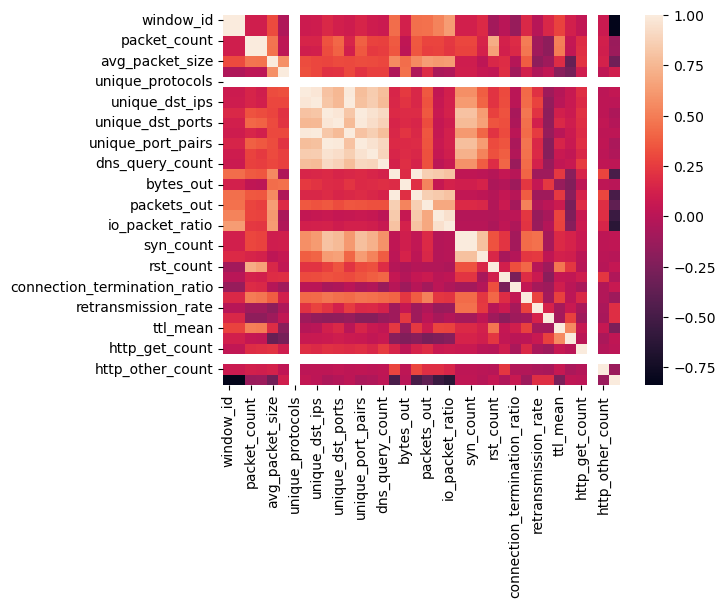

'--------------------'

"dataframe's covariance is :"

,window_id,window_start,packet_count,bytes_per_second,avg_packet_size,packet_size_std,unique_protocols,unique_src_ips,unique_dst_ips,unique_src_ports,...,connection_termination_ratio,retransmission_count,retransmission_rate,internal_external_ratio,ttl_mean,ttl_std,http_get_count,http_post_count,http_other_count,is_baseline
window_id,3.356578e+07,2.013947e+09,1.743399e+07,3.285261e+08,5.083544e+05,-3.302319e+04,0.0,5.095967e+03,5.980801e+03,4.508623e+04,...,-1355.032505,1.500077e+05,-0.914413,98.518258,3.861219e+04,1.088970e+04,41.639087,0.0,78.488396,-1.940232e+03
window_start,2.013947e+09,1.208368e+11,1.046039e+09,1.971157e+10,3.050126e+07,-1.981392e+06,0.0,3.057580e+05,3.588481e+05,2.705174e+06,...,-81301.950294,9.000461e+06,-54.864789,5911.095471,2.316731e+06,6.533819e+05,2498.345227,0.0,4709.303761,-1.164139e+05
packet_count,1.743399e+07,1.046039e+09,7.798845e+08,1.471068e+10,3.728575e+06,9.303400e+04,0.0,4.114426e+04,4.573139e+04,4.376134e+05,...,7863.393895,2.139468e+06,-83.857586,-546.928804,3.366529e+05,2.181760e+04,1078.526712,0.0,572.609257,-1.479777e+03
bytes_per_second,3.285261e+08,1.971157e+10,1.471068e+10,2.797619e+11,6.969070e+07,1.119297e+06,0.0,5.973065e+05,6.759873e+05,7.750914e+06,...,138978.611861,3.878324e+07,-1590.747986,-10218.894667,6.173599e+06,3.149612e+05,21913.884273,0.0,10068.176071,-2.663837e+04
avg_packet_size,5.083544e+05,3.050126e+07,3.728575e+06,6.969070e+07,8.301292e+04,2.304497e+04,0.0,9.553127e+02,9.474089e+02,3.863638e+03,...,-6.671338,1.665954e+04,-1.618565,-3.361133,1.287381e+03,-1.736840e+03,13.124918,0.0,6.548128,-3.595735e+01
packet_size_std,-3.302319e+04,-1.981392e+06,9.303400e+04,1.119297e+06,2.304497e+04,1.903196e+04,0.0,4.749813e+02,4.559098e+02,1.342931e+03,...,-22.559891,2.455489e+03,-0.193779,0.499291,-6.666383e+02,-6.556892e+02,2.952073,0.0,0.729873,5.890582e+00
unique_protocols,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00
unique_src_ips,5.095967e+03,3.057580e+05,4.114426e+04,5.973065e+05,9.553127e+02,4.749813e+02,0.0,1.099098e+02,1.148393e+02,3.904459e+02,...,0.090553,6.918137e+02,0.066032,-0.122089,-4.627174e+00,1.150426e+01,0.426230,0.0,0.029508,1.765027e-01
unique_dst_ips,5.980801e+03,3.588481e+05,4.573139e+04,6.759873e+05,9.474089e+02,4.559098e+02,0.0,1.148393e+02,1.257558e+02,4.268417e+02,...,0.110638,7.507614e+02,0.096112,-0.196362,-5.515411e-01,1.374889e+01,0.401543,0.0,0.036837,4.898746e-02
unique_src_ports,4.508623e+04,2.705174e+06,4.376134e+05,7.750914e+06,3.863638e+03,1.342931e+03,0.0,3.904459e+02,4.268417e+02,2.160101e+03,...,-5.379332,3.431020e+03,0.302005,-0.899884,1.261242e+02,6.224121e+01,2.000964,0.0,0.159499,-9.499839e-01


'--------------------'

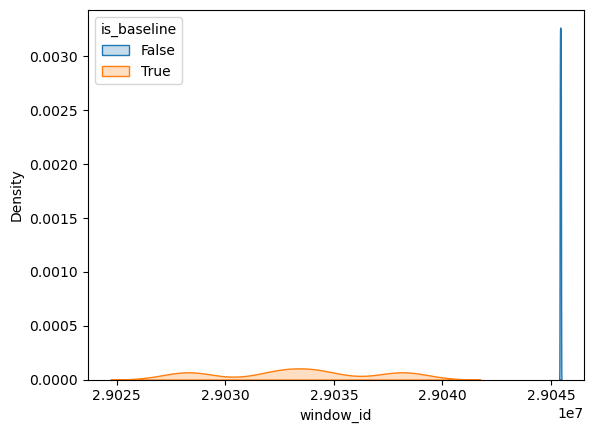

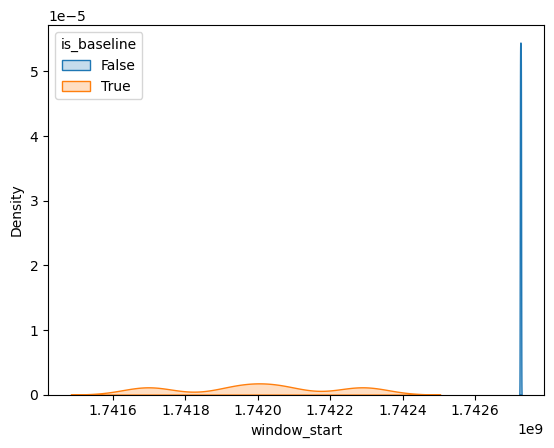

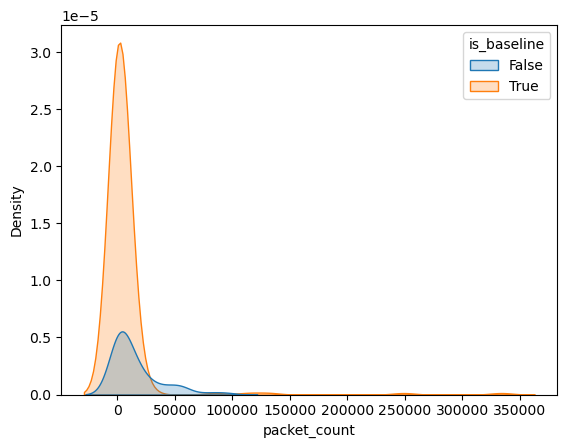

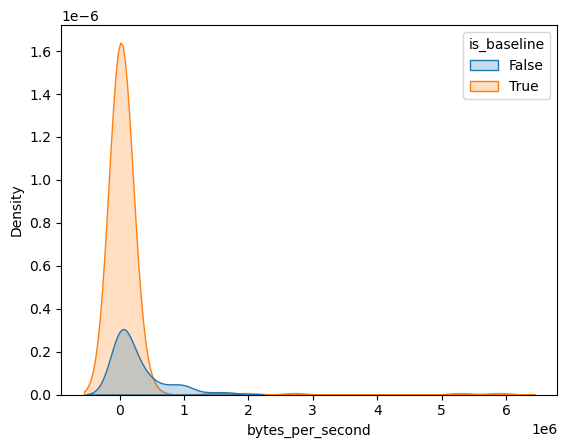

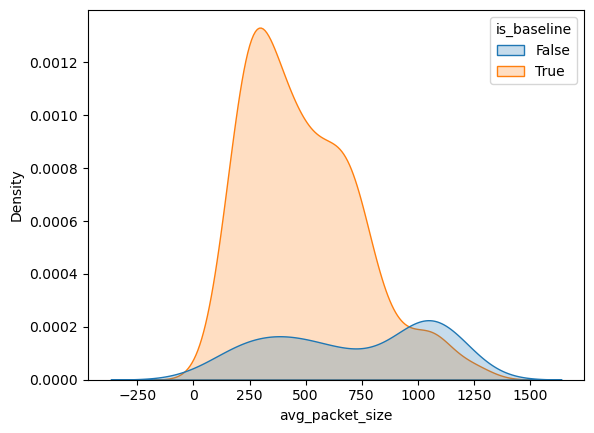

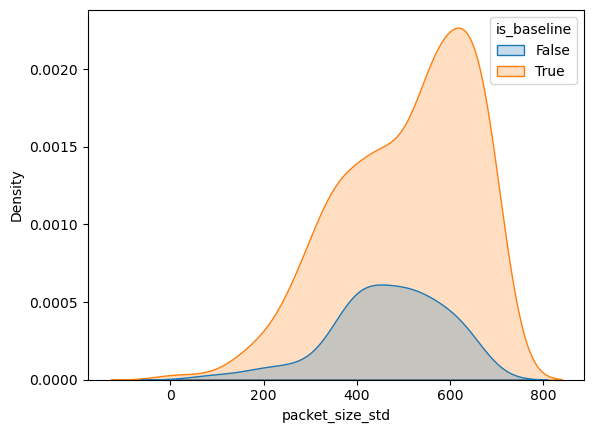

/var/folders/bl/r2644t156ysdhnf63_n5zlbr0000gn/T/ipykernel_62859/4016037139.py:86: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dataframe,x=col, hue="is_baseline",fill=True)


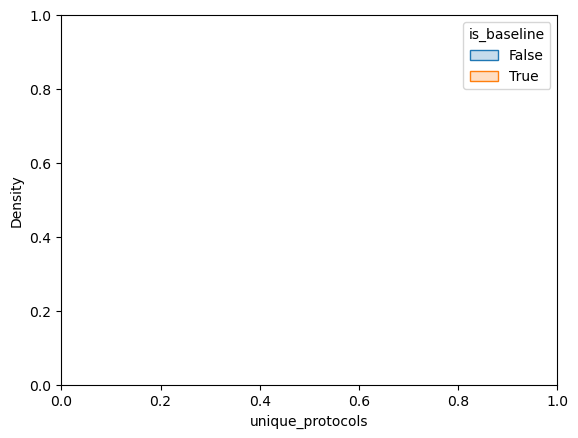

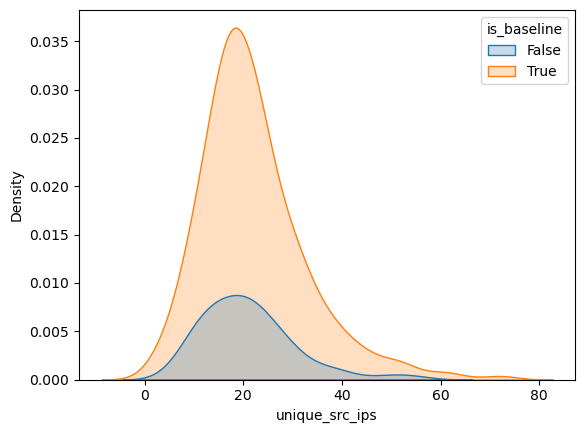

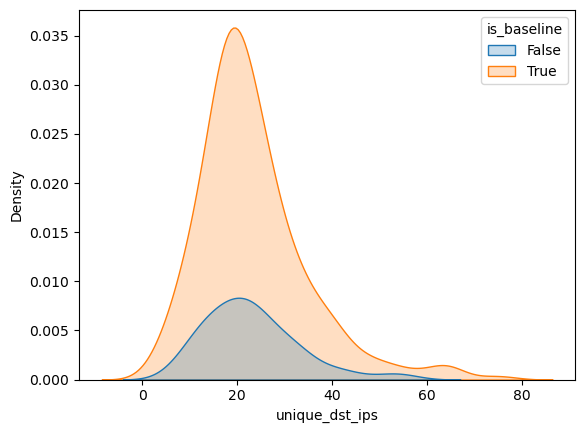

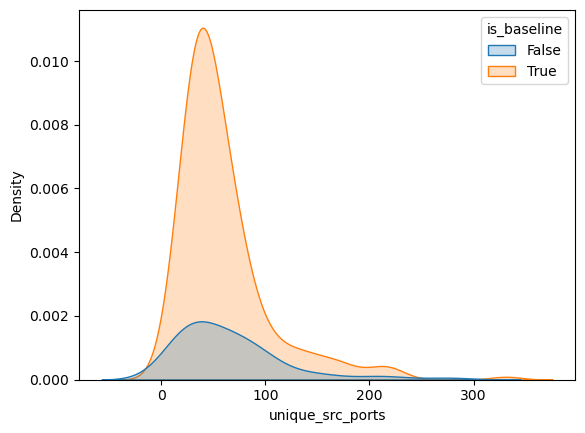

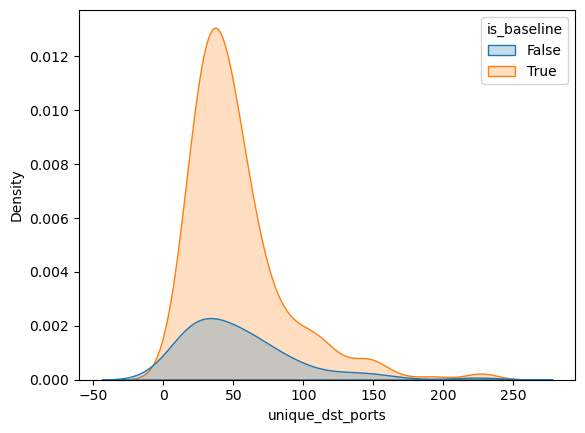

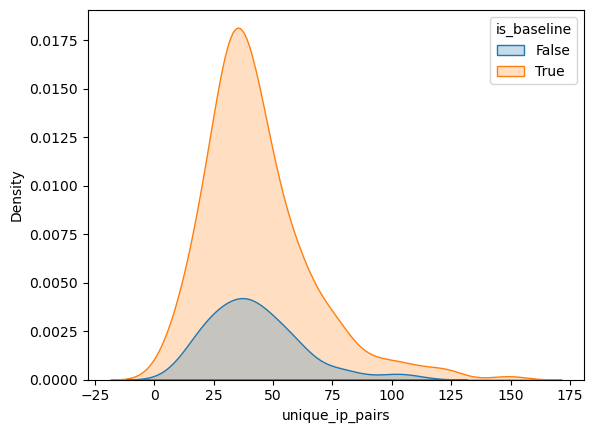

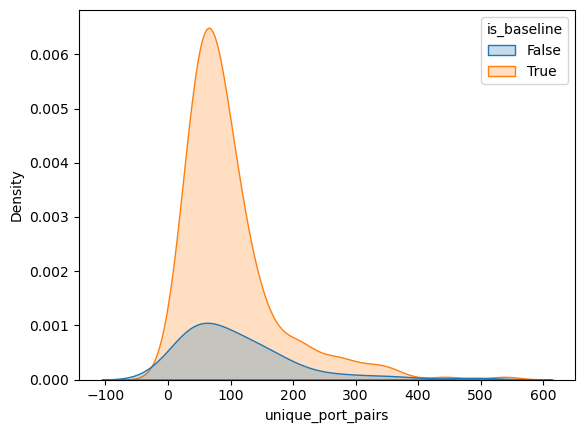

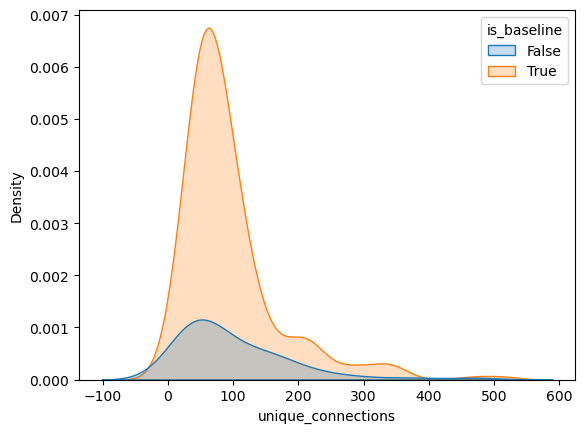

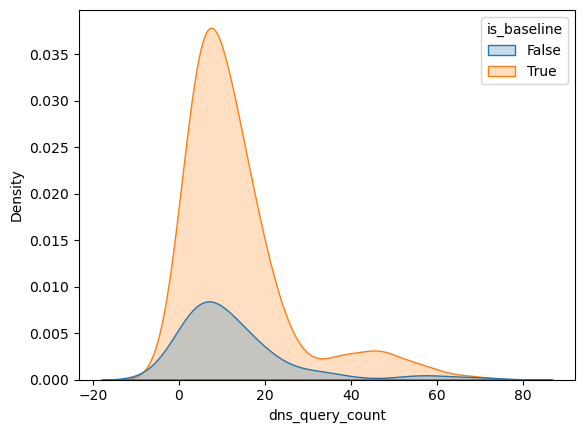

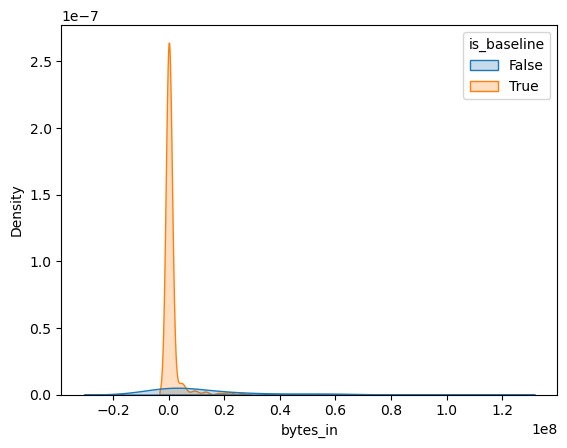

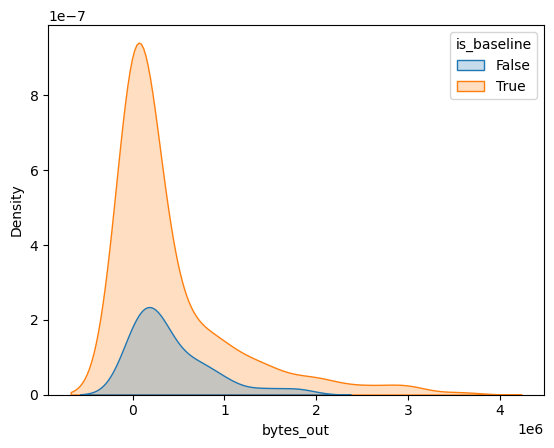

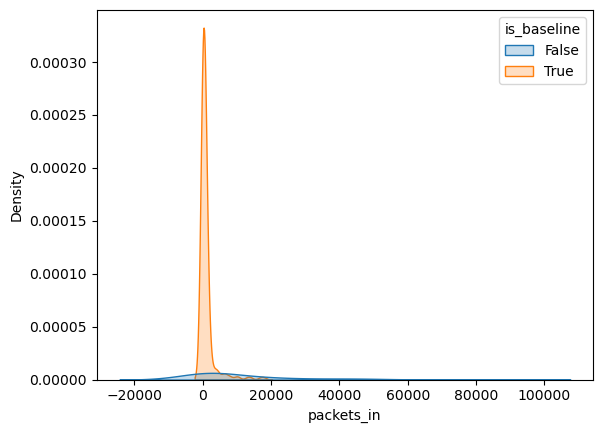

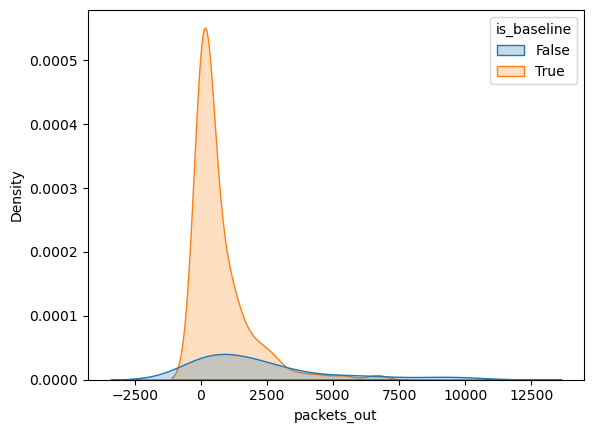

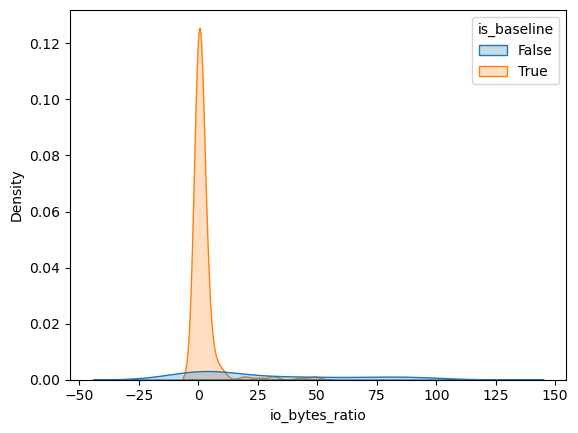

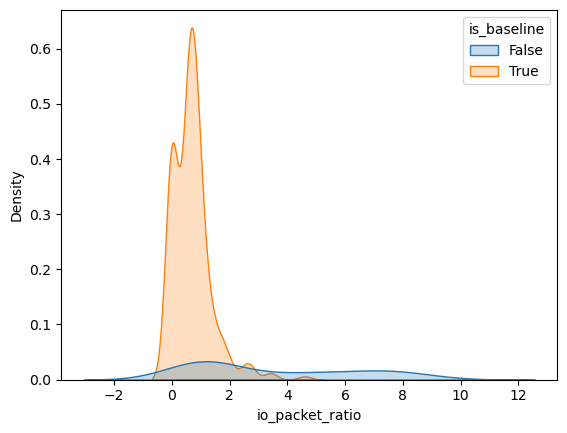

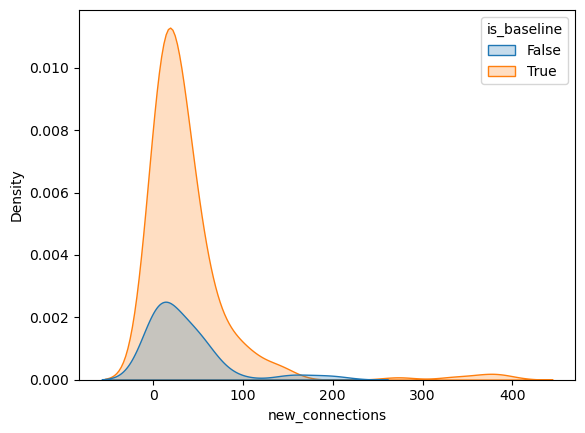

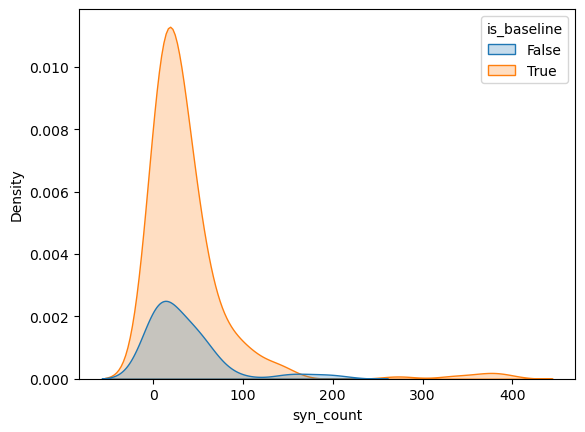

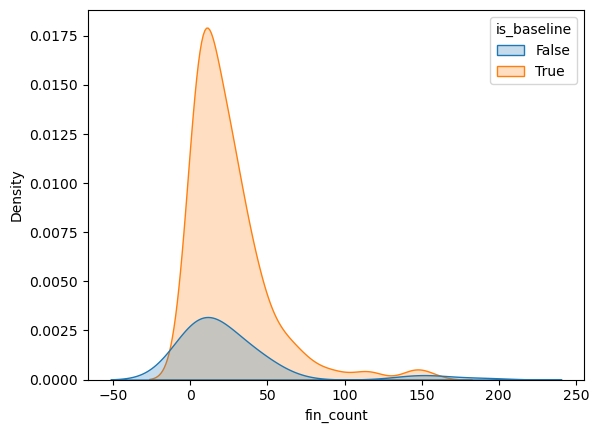

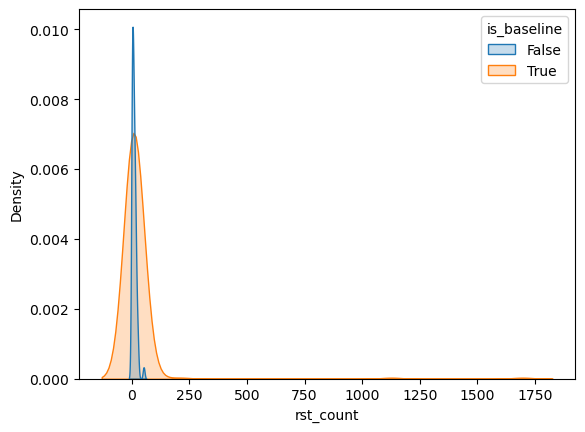

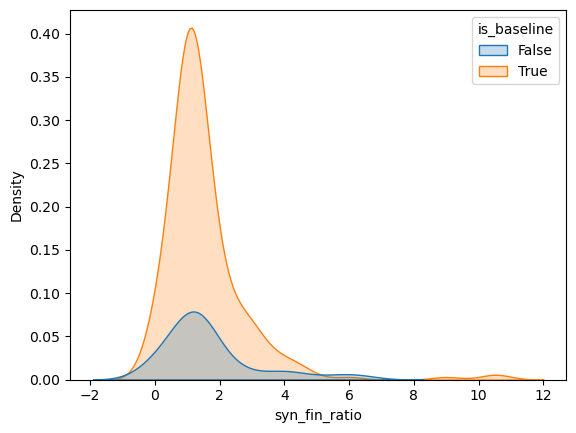

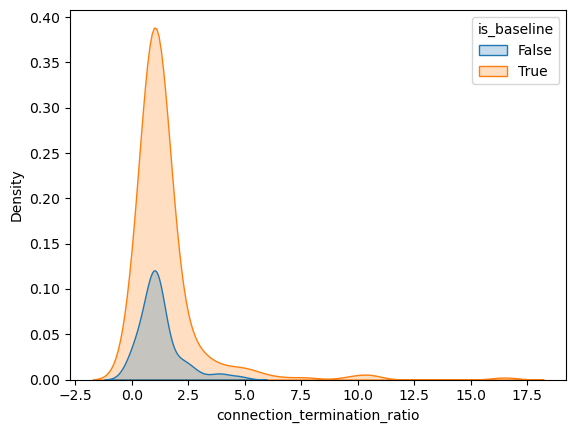

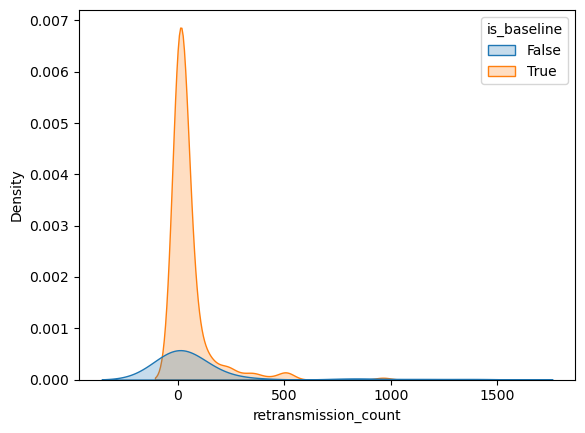

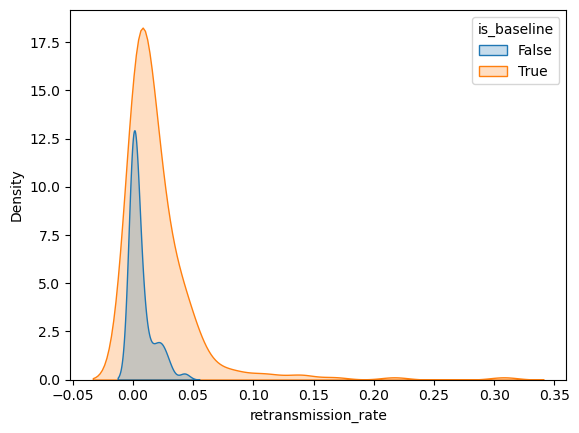

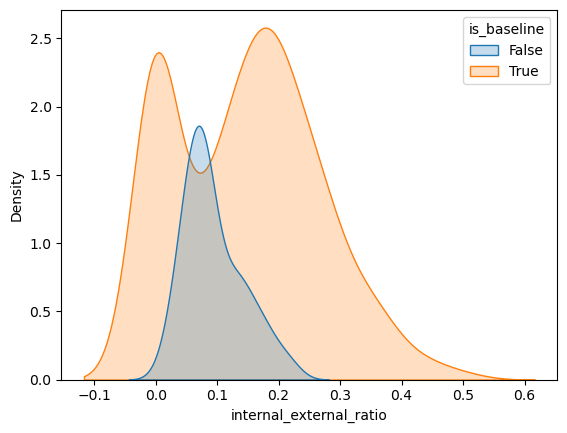

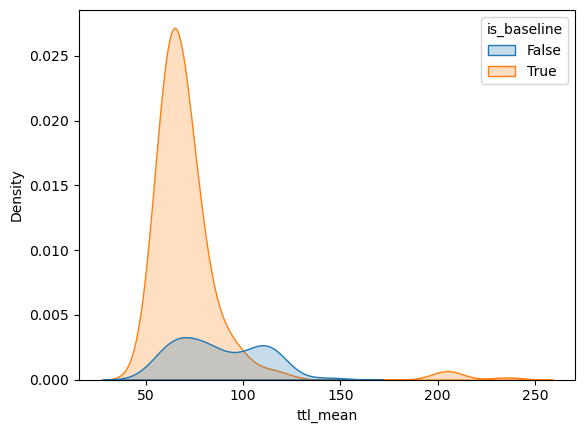

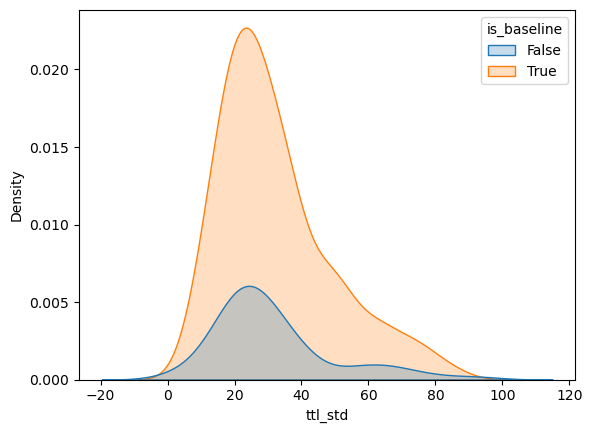

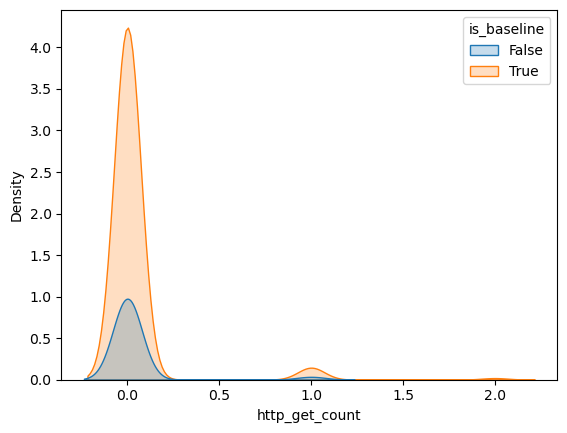

/var/folders/bl/r2644t156ysdhnf63_n5zlbr0000gn/T/ipykernel_62859/4016037139.py:86: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dataframe,x=col, hue="is_baseline",fill=True)


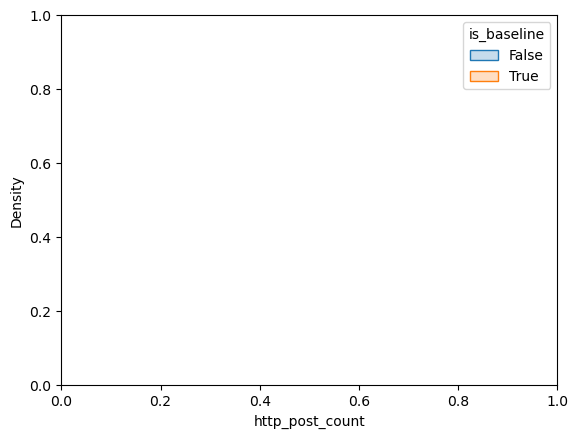

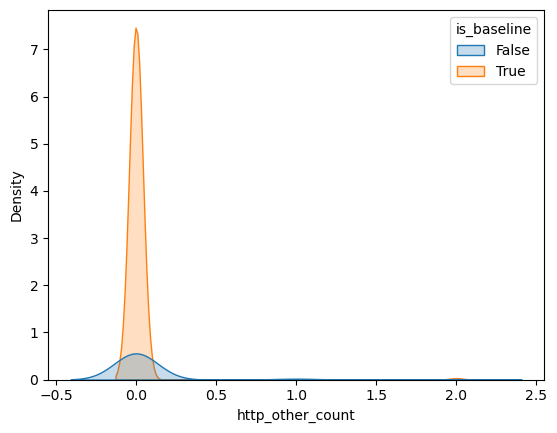

"dataframe's geometric mean is :"

'Geometric mean of column window_id is 29035723.263787676'

'Geometric mean of column window_start is 1742143395.8272617'

'Geometric mean of column packet_count is 1602.2339397544667'

'Geometric mean of column bytes_per_second is 12093.029293799029'

'Geometric mean of column avg_packet_size is 452.8563149393365'

'Geometric mean of column packet_size_std is 470.72365534009555'

'function failed for column unique_protocols due to no positive values'

'Geometric mean of column unique_src_ips is 19.50089928681187'

'Geometric mean of column unique_dst_ips is 20.870539099311003'

'Geometric mean of column unique_src_ports is 48.3165861044305'

'Geometric mean of column unique_dst_ports is 43.456664911289906'

'Geometric mean of column unique_ip_pairs is 37.915824510214804'

'Geometric mean of column unique_port_pairs is 79.08825703764799'

'Geometric mean of column unique_connections is 73.01975417674963'

'Geometric mean of column dns_query_count is 9.441271825250626'

'Geometric mean of column bytes_in is 261847.05880061266'

'Geometric mean of column bytes_out is 212177.39246368315'

'Geometric mean of column packets_in is 619.9767622673174'

'Geometric mean of column packets_out is 588.0774238095454'

'Geometric mean of column io_bytes_ratio is 1.2960207474021619'

'Geometric mean of column io_packet_ratio is 1.091540233052829'

'Geometric mean of column new_connections is 20.96469202773103'

'Geometric mean of column syn_count is 20.96469202773103'

'Geometric mean of column fin_count is 16.10738651395414'

'Geometric mean of column rst_count is 7.504114224931946'

'Geometric mean of column syn_fin_ratio is 1.3247267567357885'

'Geometric mean of column connection_termination_ratio is 1.1321431192180527'

'Geometric mean of column retransmission_count is 13.968792872216936'

'Geometric mean of column retransmission_rate is 0.00790429115394518'

'Geometric mean of column internal_external_ratio is 0.14662152921893895'

'Geometric mean of column ttl_mean is 72.46420018382472'

'Geometric mean of column ttl_std is 28.02147678753754'

'Geometric mean of column http_get_count is 1.0650410894399627'

'function failed for column http_post_count due to no positive values'

'Geometric mean of column http_other_count is 1.414213562373095'

'Geometric mean of column window_id is 29035723.263787676'

'Geometric mean of column window_start is 1742143395.8272617'

'Geometric mean of column packet_count is 1602.2339397544667'

'Geometric mean of column bytes_per_second is 12093.029293799029'

'Geometric mean of column avg_packet_size is 452.8563149393365'

'Geometric mean of column packet_size_std is 470.72365534009555'

'function failed for column unique_protocols due to no positive values'

'Geometric mean of column unique_src_ips is 19.50089928681187'

'Geometric mean of column unique_dst_ips is 20.870539099311003'

'Geometric mean of column unique_src_ports is 48.3165861044305'

'Geometric mean of column unique_dst_ports is 43.456664911289906'

'Geometric mean of column unique_ip_pairs is 37.915824510214804'

'Geometric mean of column unique_port_pairs is 79.08825703764799'

'Geometric mean of column unique_connections is 73.01975417674963'

'Geometric mean of column dns_query_count is 9.441271825250626'

'Geometric mean of column bytes_in is 261847.05880061266'

'Geometric mean of column bytes_out is 212177.39246368315'

'Geometric mean of column packets_in is 619.9767622673174'

'Geometric mean of column packets_out is 588.0774238095454'

'Geometric mean of column io_bytes_ratio is 1.2960207474021619'

'Geometric mean of column io_packet_ratio is 1.091540233052829'

'Geometric mean of column new_connections is 20.96469202773103'

'Geometric mean of column syn_count is 20.96469202773103'

'Geometric mean of column fin_count is 16.10738651395414'

'Geometric mean of column rst_count is 7.504114224931946'

'Geometric mean of column syn_fin_ratio is 1.3247267567357885'

'Geometric mean of column connection_termination_ratio is 1.1321431192180527'

'Geometric mean of column retransmission_count is 13.968792872216936'

'Geometric mean of column retransmission_rate is 0.00790429115394518'

'Geometric mean of column internal_external_ratio is 0.14662152921893895'

'Geometric mean of column ttl_mean is 72.46420018382472'

'Geometric mean of column ttl_std is 28.02147678753754'

'Geometric mean of column http_get_count is 1.0650410894399627'

'function failed for column http_post_count due to no positive values'

'Geometric mean of column http_other_count is 1.414213562373095'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(-26.65765230280226), pvalue=np.float64(1.495752755155351e-81), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(-26.657652302797345), pvalue=np.float64(1.4957527552140993e-81), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(-2.329281369210409), pvalue=np.float64(0.020499135000335508), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(-2.211973301634018), pvalue=np.float64(0.027711885673422792), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(-5.723135539492389), pvalue=np.float64(2.5064290423195738e-08), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(1.871123353544678), pvalue=np.float64(0.06228841263112407), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(0.7342049785097299), pvalue=np.float64(0.4633897233378378), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(0.1903470843156563), pvalue=np.float64(0.8491642052211656), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(-0.8917557927142327), pvalue=np.float64(0.3732291221711357), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(-0.3885955029319916), pvalue=np.float64(0.6978474064170428), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(0.3530380294383468), pvalue=np.float64(0.7243045987134735), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(-1.02185708006742), pvalue=np.float64(0.30766102834476233), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(-0.6382646518767575), pvalue=np.float64(0.5237819287816986), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(0.3675989368672952), pvalue=np.float64(0.7134280975043943), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(-9.506673901714953), pvalue=np.float64(6.2183189204664425e-19), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(0.024054113171127937), pvalue=np.float64(0.9808252263766056), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(-9.678567765125026), pvalue=np.float64(1.730402852463875e-19), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(-7.13998328502132), pvalue=np.float64(6.908359793816924e-12), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(-11.678859805123468), pvalue=np.float64(2.7809126134739776e-26), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(-14.290383435386309), pvalue=np.float64(8.582195696005203e-36), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(0.4252598225274063), pvalue=np.float64(0.6709481466257078), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(0.4252598225274063), pvalue=np.float64(0.6709481466257078), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(-0.20033341897312493), pvalue=np.float64(0.8413537798173685), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(0.8007727497357042), pvalue=np.float64(0.4238885959466234), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(-0.6419499972725262), pvalue=np.float64(0.5213894116894685), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(1.14439469690979), pvalue=np.float64(0.25336022960992627), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(-2.0562743548077624), pvalue=np.float64(0.04060949521918308), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(3.4720143763049527), pvalue=np.float64(0.0005914673600265267), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(3.440471706135421), pvalue=np.float64(0.000661937696248569), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(-4.728376579116387), pvalue=np.float64(3.4681909063278877e-06), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(0.45435603020596416), pvalue=np.float64(0.6498968349466077), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(0.2660237748589608), pvalue=np.float64(0.790401228163199), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.float64(304.0))'

'Statistical significance of the difference between the two sets is TtestResult(statistic=np.float64(-2.24363126319522), pvalue=np.float64(0.025575899363112435), df=np.float64(304.0))'

In [86]:
get_stats(adv_df)

In [87]:
### Hypothesis tests for the baseline and non-baseline columns.
## from the comparison it can be seen taht some of the geometric means of the columns might be statiscally significant 
## if p-value is less than 0.05. means that the two sets are differnet in terms of the column's values.

##columns which their geometric means are statistically significant are:
##

## comparison of the two set's geometric means and if they are statistically significant.
significance_list = []
for col in adv_df.select_dtypes(include=["number"]).columns:
    baseline_values = adv_df[col][adv_df["is_baseline"] == True].dropna()
    non_baseline_values = adv_df[col][adv_df["is_baseline"] == False].dropna()
    if len(baseline_values) != 0 and len(non_baseline_values) != 0:
        #display(f"Geometric mean of column {col} for baseline is {scipy.stats.gmean(baseline_values)}")
        #display(f"Geometric mean of column {col} for non-baseline is {scipy.stats.gmean(non_baseline_values)}")
        ##display(f"Statistical significance of the difference between the two sets is {scipy.stats.ttest_ind(baseline_values, non_baseline_values)}")
        if scipy.stats.ttest_ind(baseline_values, non_baseline_values).pvalue < 0.05:
            significance_list.append({
                "column name": col,
                "t-test": scipy.stats.ttest_ind(baseline_values, non_baseline_values).statistic,
                "p-val": float(scipy.stats.ttest_ind(baseline_values, non_baseline_values).pvalue),
                "df": scipy.stats.ttest_ind(baseline_values, non_baseline_values).df
            })

        significance_df = pd.DataFrame(significance_list)
    else: 
        display(f"function failed for column {col} due to no positive values")      
display(significance_df)


## these columns must be explored throughly because of their statisctical significance.!!!!!

,column name,t-test,p-val,df
0,window_id,-26.657652,1.495753e-81,304.0
1,window_start,-26.657652,1.495753e-81,304.0
2,packet_count,-2.329281,2.049914e-02,304.0
3,bytes_per_second,-2.211973,2.771189e-02,304.0
4,avg_packet_size,-5.723136,2.506429e-08,304.0
5,bytes_in,-9.506674,6.218319e-19,304.0
6,packets_in,-9.678568,1.730403e-19,304.0
7,packets_out,-7.139983,6.908360e-12,304.0
8,io_bytes_ratio,-11.678860,2.780913e-26,304.0
9,io_packet_ratio,-14.290383,8.582196e-36,304.0


# **interpretation of the t-test and p values**.

### **When t-test is negative, then the baseline values are less than the non-baseline values.**

window_id, window_start = window id's are different because the the baseline information has been captured on the first 4 days with intervals between them.
There is 2 days difference between the 2. baseline and the 3rd. After the 4th day, anomalies has been captured.

packet_count,bytes_per_second, avg_packet_size, bytes_in, packets_in = Packet counts are statistically significant in terms of the differences because of the constant download of the mini-big packages with the bash script that's been executed to collect anomaly data.

io_bytes_ratio, io_packet_ratio = These features are different because i had been downloading large packages without sending them. In the bash script, Artifically generated packets were constantly getting dumped into the /dev/null.
This behaviour of the script created a literal difference between the internal and external network traffic.


retransmission_count = All the information about retransmission is statisctically significant between the baseline and non-baseline rows. That's more likely on about not having enough external network on the anomaly generation. Also, the t-test value of this is might be negative but it is not a big much of a difference(-2) because the baseline is consisting of 4 days of data and the anomaly data is only 1 .


### **if the t-test is positive then the baseline values are greater than the non-baseline values.**

retransmission_rate = retransmission rate of the baseline is bigger than the non-baseline values becuase the data is again consists of mostly baseline rows.(80% to 20%)
internal_external_ratio = I am not quite sure why this column is like this ? beacuse anomaly generation has been downloading like 5gbs of packages for 10 minutes. explore this columns later.



## Pre-Processing the data.

Getting rid of the unusual columns. (http_post_count and unique_protocols)

In [88]:
adv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   window_id                     306 non-null    int64  
 1   window_start                  306 non-null    int64  
 2   packet_count                  306 non-null    int64  
 3   bytes_per_second              306 non-null    float64
 4   avg_packet_size               306 non-null    float64
 5   packet_size_std               306 non-null    float64
 6   unique_protocols              306 non-null    int64  
 7   unique_src_ips                306 non-null    int64  
 8   unique_dst_ips                306 non-null    int64  
 9   unique_src_ports              306 non-null    int64  
 10  unique_dst_ports              306 non-null    int64  
 11  unique_ip_pairs               306 non-null    int64  
 12  unique_port_pairs             306 non-null    int64  
 13  uniqu

In [ ]:
## decapreting the feture with the 1 unique value.
#http_post_count and unique_protocols features have only 1 unique value. They will not add to much of a value to the model.
## a crossfold is needed because data is not mixed up. ie. the anomalies are at the end of the dataset. 

def preprocess_data(dataframe = pd.DataFrame()) -> dict:
    #http_post_count and unique_protocols features have only 1 unique value. They will not add to much of a value to the model.
    columns_to_drop = ["http_post_count", "unique_protocols","file_source"]
    for col in columns_to_drop:
        if col in dataframe.columns:
            dataframe.drop(col, axis=1, inplace=True)
    ##file_source is not important because it only shows the pcap file name.
    ## mapping the bool value to float values.
    map = {True: 1.0, False: 0.0}
    if dataframe["is_baseline"].dtype != bool:
        dataframe["is_baseline"] = dataframe["is_baseline"].map(map)
    if "is_baseline" not in dataframe.columns.names:

        X_baseline = dataframe[dataframe["is_baseline"] == True].drop(["is_baseline"],axis=1).to_numpy()
        X_anomaly = dataframe[dataframe["is_baseline"] == False].drop(["is_baseline"],axis=1).to_numpy()

        ##Separate Normalization Normalize baseline and anomaly rows independently
        scaler = RobustScaler()
        X_baseline = scaler.fit_transform(X_baseline)
        X_anomaly = scaler.transform(X_anomaly)  
        
        # ##PCA
        # pca = PCA(n_components=0.95)
        # X_baseline = pca.fit_transform(X_baseline)
        # X_anomaly = pca.transform(X_anomaly)
        ##Feature Selection
        y_baseline = np.ones(X_baseline.shape[0])
        y_anomaly = np.zeros(X_anomaly.shape[0])
        selector = SelectKBest(score_func=mutual_info_classif, k=20)
        X_baseline = selector.fit_transform(X_baseline, y_baseline)
        X_anomaly = selector.transform(X_anomaly) 

        # display(X_anomaly.shape)
        # display(X_baseline.shape)
        X = np.concatenate((X_baseline, X_anomaly))
        Y = np.concatenate((y_baseline, y_anomaly))
        
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3,stratify=Y)
    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.5, stratify=Y_test)

    return {"X_train":X_train,
            "X_val":X_val,
            "X_test":X_test,
            "Y_train":Y_train,
            "Y_val":Y_val,
            "Y_test":Y_test}

## Generating DataSet object

In [90]:
### building  a ANN model to detect anomalies in the data.
from torch import nn
import torch
from torch.utils.data import DataLoader, Dataset ## for the data loading and processing.

class Dataset(Dataset):
    def __init__(self,X,Y):
        self.X = torch.tensor(data=X,dtype = torch.float32).to(device = device)
        self.Y = torch.tensor(data = Y, dtype=torch.float32 ).to(device = device)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,idx):
        return self.X[idx],self.Y[idx]

In [112]:
process = preprocess_data(adv_df)
# process_df_train = pd.DataFrame(process["X_train"])
# process_df_test = pd.DataFrame(process["Y_train"])
# display(process_df_train.describe())
# display(process_df_test.describe())
train_set = Dataset(process["X_train"],process["Y_train"])
test_set = Dataset(process["X_test"],process["Y_test"])
val_set = Dataset(process["X_val"],process["Y_val"])
train_set.__getitem__(10)

(61, 20)

(245, 20)

(tensor([ 0.1667, 28.2317,  0.2792,  6.7184,  0.8861, 19.9699,  3.9266,  0.5625,
          0.5625,  0.5200,  0.7500,  0.1329,  0.0527,  4.6053,  0.8928, -0.3173,
          2.3974,  0.2009,  0.0000,  0.0000], device='mps:0'),
 tensor(0., device='mps:0'))

## Defining DataLoader 

In [113]:
from torch.utils.data import RandomSampler, BatchSampler

def loaders(train, test, val) -> dict[str,any]:
    
    loaders = {"train":train, "test":test, "validation":val}

    for key, val in loaders.items():

        loaders[key] = DataLoader(dataset=val, batch_sampler = 
                                  BatchSampler(
            sampler=RandomSampler(val),
            batch_size=8,
            drop_last=True
            )
        )

    print(loaders)
    return loaders["train"], loaders["test"], loaders["validation"]

In [ ]:
train_dataloader, test_dataloader, val_dataloader = loaders(train_set, test_set, val_set)
for x, y in train_dataloader:
    display("-"*5)
    display(x)
    display("-"*5)
    display(y)
    display("-"*5)
    break


{'train': <torch.utils.data.dataloader.DataLoader object at 0x1661492b0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x30548c050>, 'validation': <torch.utils.data.dataloader.DataLoader object at 0x30548ca50>}


'-----'

tensor([[ 9.1667e-01,  1.8637e-01,  3.3640e-01,  7.2289e-02,  8.0460e-02,
          1.6182e-01,  1.0522e-01, -3.7500e-01, -3.7500e-01, -3.6000e-01,
         -5.0000e-01,  0.0000e+00, -3.6905e-01,  7.8947e-01,  2.1617e+00,
          5.4907e-01,  6.2924e-01,  6.6845e-01,  0.0000e+00,  0.0000e+00],
        [ 4.1667e-01, -2.6445e-01, -6.9813e-02, -1.4759e-01, -8.6729e-02,
          2.0415e-01, -9.4984e-02, -1.2500e-01, -1.2500e-01, -3.6000e-01,
         -8.3333e-02,  9.4480e-01, -4.9206e-01,  1.5789e-01,  1.5510e+00,
          2.3077e-01,  9.1203e-01,  1.2026e+00,  0.0000e+00,  0.0000e+00],
        [ 3.0000e+00,  4.4555e+00,  6.1814e-01,  1.8825e+00,  1.1630e+00,
          1.7258e+00,  4.6553e-01,  3.7500e+00,  3.7500e+00,  3.7200e+00,
          5.2500e+00,  1.0123e-01,  2.5628e-01,  4.7368e-01, -1.8496e-01,
         -2.3389e-02,  1.3832e-01,  3.2895e-01,  0.0000e+00,  0.0000e+00],
        [ 1.2500e+00,  1.5254e+00,  4.8036e+00,  2.0000e+00,  2.2466e+00,
         -7.0013e-02,  4.8108e-03, 

'-----'

tensor([1., 1., 1., 1., 1., 1., 1., 1.], device='mps:0')

'-----'

## Defining ANN for Detection.

In [ ]:


class TabularAnomalyClassifier(nn.Module):
    def __init__(self, input_dim, hidden_layers=[64, 32], dropout_rate=0.2):
        super().__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Hidden layers
        for h_dim in hidden_layers:
            layers.extend([
                nn.Linear(prev_dim, h_dim),
                nn.BatchNorm1d(h_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = h_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())  # Binary classification
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)




In [ ]:


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    """
    Training loop for the anomaly classification model
    
    Args:
        model (TabularAnomalyClassifier): Neural network model
        train_loader (DataLoader): Training data loader
        val_loader (DataLoader): Validation data loader
        criterion (nn.Module): Loss function
        optimizer (torch.optim): Optimizer
        epochs (int): Number of training epochs
    """
    device = "mps"
    model.to(device)
    
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y.float())
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_preds, val_true = [], []
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                outputs = model(batch_X).squeeze()
                loss = criterion(outputs, batch_y.float())
                
                val_loss += loss.item()
                val_preds.extend((outputs > 0.5).cpu().numpy())
                val_true.extend(batch_y.cpu().numpy())
        
        # Print epoch summary
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        # Optional: Print classification report
        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print(classification_report(val_true, val_preds))
        
        # Model checkpoint
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
    
    return model

def evaluate_model(model, test_loader):
    """
    Evaluate the trained model on test data
    
    Args:
        model (TabularAnomalyClassifier): Trained neural network model
        test_loader (DataLoader): Test data loader
    
    Returns:
        dict: Classification metrics
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    test_preds, test_true = [], []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs = model(batch_X).squeeze()
            test_preds.extend((outputs > 0.5).cpu().numpy())
            test_true.extend(batch_y.cpu().numpy())
    
    # Generate classification report and confusion matrix
    print("Classification Report:")
    print(classification_report(test_true, test_preds))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(test_true, test_preds))
    
    return {
        'classification_report': classification_report(test_true, test_preds, output_dict=True),
        'confusion_matrix': confusion_matrix(test_true, test_preds)
    }

def main(train_loader, val_loader, test_loader, input_dim):
    """
    Main training and evaluation pipeline
    
    Args:
        train_loader (DataLoader): Training data loader
        val_loader (DataLoader): Validation data loader
        test_loader (DataLoader): Test data loader
        input_dim (int): Number of input features
    """
    # Initialize model
    model = TabularAnomalyClassifier(input_dim)
    
    # Loss and optimizer
    criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Train model
    trained_model = train_model(model, train_loader, val_loader, criterion, optimizer)
    
    # Evaluate model
    evaluate_model(trained_model, test_loader)

# Example usage in your main script
# main(train_loader, val_loader, test_loader, input_dim=X.shape[1])